In [1]:
import numpy as np
import matplotlib.pyplot as plt

DEFAULT_SEED = 42

from gaussian import MultivariateNormal, DynamicMultivariateNormal, VarianceExploding, VariancePreserving, SubVariancePreserving

In [2]:
num_sides = 6
th = 2.0 * np.pi / num_sides
rot_th = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])

var = np.diag([5.0, 0.5])
mean = np.array([0.0, 5.0])
norms = []
for _ in range(num_sides):
    norms.append(DynamicMultivariateNormal(2, mean, var))
    var = rot_th @ var @ rot_th.T
    mean = rot_th @ mean

### Forward time SDE

In [34]:
def simulate(mix, tf=1.0, nt=50_000, save_every=250, num_sample=2000, noise_weight=1.0, seed=DEFAULT_SEED):
    x_init = mix.sample(num_sample)
    dt = tf / nt
    t = np.linspace(0.0, tf, nt + 1)

    num_save = nt // save_every
    x = x_init[:, None, :].repeat(num_save + 1, 1)

    rng = np.random.default_rng(seed)

    x_cur = x_init
    for i in range(1, nt + 1):
        t_cur = t[i - 1]
        dw = np.sqrt(dt) * rng.normal(size=x_cur.shape)
        x_cur = x_cur + dt * mix.f(t_cur, x_cur) + noise_weight * mix.g(t_cur) * dw
        if i % save_every == 0:
            x[:, i // save_every, :] = x_cur

    return t[::save_every], x


def plot_simulation(mix, t, x, show_every=50):
    num_plots = (len(t) - 1) // show_every + 1
    fig, ax = plt.subplots(1, num_plots, figsize=(15, 3))


    for i in range(num_plots):
        si = i * show_every
        ti = t[si]
        xi = x[:, si, :]

        x1_cont = np.linspace(xi[:, 0].min() - 0.5, xi[:, 0].max() + 0.5, 200)
        x2_cont = np.linspace(xi[:, 1].min() - 0.5, xi[:, 1].max() + 0.5, 200)
        x_cont = np.stack(np.meshgrid(x1_cont, x2_cont), -1)
    
        ax[i].scatter(*xi.T, s=1)
        ax[i].contour(x_cont[:, :, 0], x_cont[:, :, 1], np.log(mix.density(ti, x_cont)), levels=10, alpha=0.5, cmap="plasma")
    return fig, ax

#### No movement

(<Figure size 1500x300 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

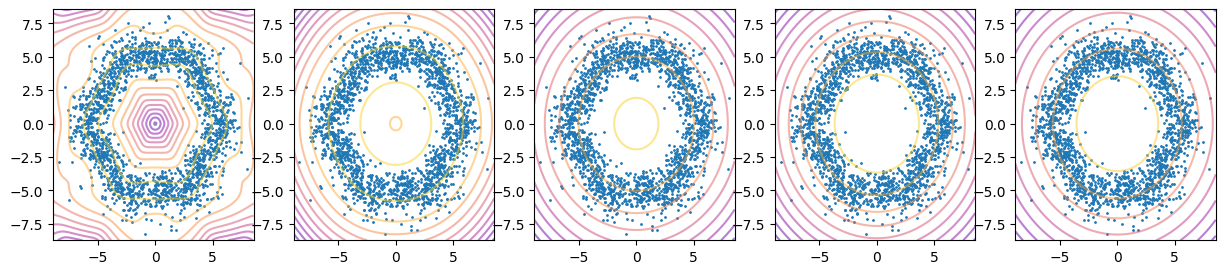

In [35]:
mix = VarianceExploding(tuple(norms))

t, x = simulate(mix, tf=10.0, noise_weight=0.0)
plot_simulation(mix, t, x)

#### Pure noise

(<Figure size 1500x300 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

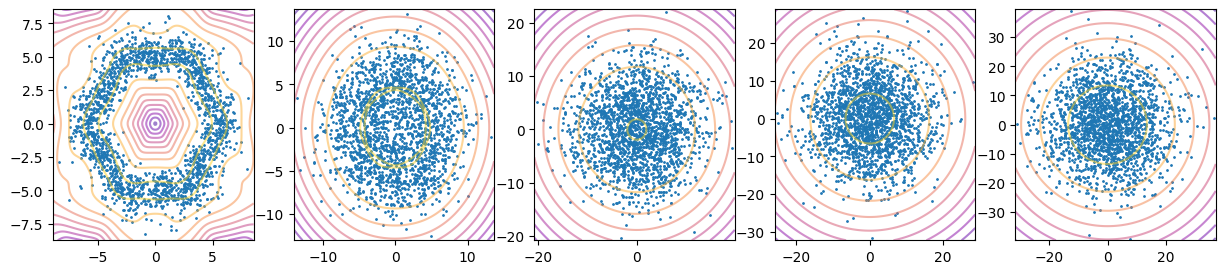

In [36]:
mix = VarianceExploding(tuple(norms))

t, x = simulate(mix, tf=10.0)
plot_simulation(mix, t, x)

(<Figure size 1500x300 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

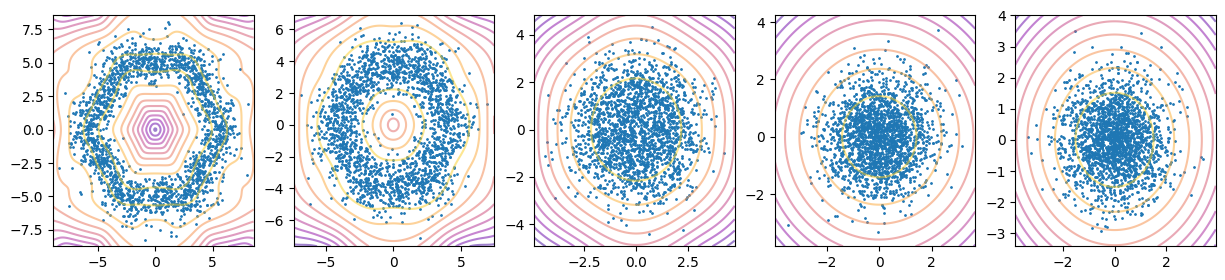

In [37]:
mix = VariancePreserving(tuple(norms))

t, x = simulate(mix)
plot_simulation(mix, t, x)

(<Figure size 1500x300 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

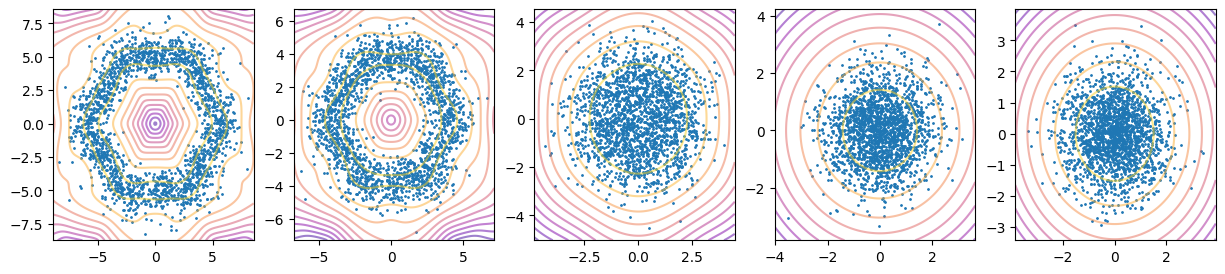

In [40]:
mix = SubVariancePreserving(tuple(norms))

t, x = simulate(mix)
plot_simulation(mix, t, x)

### Backwards time ODE

In [18]:
tf_ve = 20.0
mix = VarianceExploding(tuple(norms))

# # real final covariance
# final_cov = 0.0
# scaling_sq_tf = mix.scaling(tf_ve) ** 2
# added_noise_sq_tf = mix.added_noise_sq(tf_ve) * np.eye(mix.dim)
# for wk, rvk in zip(mix.weights, mix.rv):
#     final_cov += wk * (scaling_sq_tf * rvk.cov.cov + added_noise_sq_tf)

prior_ve = MultivariateNormal(mix.dim, cov=mix.added_noise_sq(tf_ve))
x_noisy = prior_ve.sample(1000)

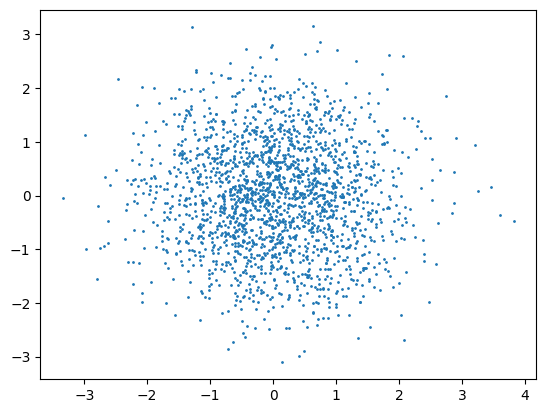

In [20]:
plt.scatter(*np.random.randn(2, 2000), s=1)